## Spam Email Classifier with KNN using TF-IDF scores

1.   Assignment must be implemented in Python 3 only.
2.   You are allowed to use libraries for data preprocessing (numpy, pandas, nltk etc) and for evaluation metrics, data visualization (matplotlib etc.).
3.   You will be evaluated not just on the overall performance of the model and also on the experimentation with hyper parameters, data prepossessing techniques etc.
4.   The report file must be a well documented jupyter notebook, explaining the experiments you have performed, evaluation metrics and corresponding code. The code must run and be able to reproduce the accuracies, figures/graphs etc.
5.   For all the questions, you must create a train-validation data split and test the hyperparameter tuning on the validation set. Your jupyter notebook must reflect the same.
6.   Strict plagiarism checking will be done. An F will be awarded for plagiarism.

**Task: Given an email, classify it as spam or ham**

Given input text file ("emails.txt") containing 5572 email messages, with each row having its corresponding label (spam/ham) attached to it.

This task also requires basic pre-processing of text (like removing stopwords, stemming/lemmatizing, replacing email_address with 'email-tag', etc..).

You are required to find the tf-idf scores for the given data and use them to perform KNN using Cosine Similarity.

### Import necessary libraries

In [46]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
import re, math
import numpy as np

stopwords_set = set(stopwords.words('english'))
stemmer = SnowballStemmer(language='english')

### Load dataset

In [47]:
with open('emails.txt', 'r') as file:
    crudeData = file.readlines()

### Preprocess data

In [48]:
verdict = [0]
score = dict()
modValue = dict()
idf = dict()
stemmedWords = dict()
id = 0
for line in crudeData:
    id += 1
    line = line.casefold()
    splitt = re.split(r'[^A-Za-z0-9]+', line)
    if len(splitt) < 2:
        print(id, splitt)
        continue
    verdict.append(0)
    if splitt[0] == "spam":
        verdict[id] = 1
    else:
        verdict[id] = 0

    totalCount = len(splitt) - 1
    counts = dict()
    for i in splitt[1:-1]:
        if i == '':
            continue
        if i not in stopwords_set:
            if i not in stemmedWords:
                stemmedWords[i] = stemmer.stem(i)
            if stemmedWords[i] not in counts:
                counts[stemmedWords[i]] = 0
            counts[stemmedWords[i]] += 1
    
    for word in counts:
        if word not in idf:
            idf[word] = 1
        else:
            idf[word] += 1

    score[id] = dict()
    modValue[id] = 0
    for word in counts:
        score[id][word] = math.log(1 + counts[word])
        modValue[id] += score[id][word]**2
    modValue[id] = (modValue[id])**(0.5)

totalDocuments = id

for i in range(1, totalDocuments + 1):
    for word in score[i]:
        score[i][word] *= math.log(totalDocuments/idf[word])

def distanceFunction(a, b, distanceMethod):
    global modValue, score
    similarity = 0
    if modValue[a] * modValue[b] == 0 or a == b:
        return 0
    if distanceMethod == 'cosine':
        for word in score[a]:
            if word in score[b]:
                similarity += score[b][word]*score[a][word]
        similarity /= (modValue[a]*modValue[b])
    elif distanceMethod == 'manhattan':
        for word in score[a]:
            if word in score[b]:
                similarity += np.absolute(score[a][word] - score[b][word])
            else:
                similarity += np.absolute(score[a][word])
        for word in score[b]:
            if word not in score[a]:
                similarity += np.absolute(score[b][word])
        similarity *= -1
    else:
        for word in score[a]:
            if word in score[b]:
                similarity += (score[a][word] - score[b][word])**2
            else:
                similarity += (score[a][word])**2
        for word in score[b]:
            if word not in score[a]:
                similarity += (score[b][word])**2
        similarity *= -1
    return similarity
dist = dict()
# for i in range(1, id):
#     for j in range(1, id):
#         dist[i].append([cosineSimilarity(i, j), j])
#     dist[i].sort(reverse=True)
        


### Split data

In [49]:

x = np.arange(id+1)
x_train, x_validation, y_train, y_validation = train_test_split(x[1:], verdict[1:], test_size = 0.2, random_state=13)

### Train your KNN model (reuse previously iplemented model built from scratch) and test on your data

In [50]:
from sklearn import metrics as skm

'''find knn,
iterate over a set of k and for each k,
try different criteria to assign a verdict on spam or not spam

based on the result from above, plot a graph to understand
which parameters performed the best'''
def KNNAlgorithm(k, dist, metrics, displayConfusion):
    global x_train, x_validation, y_train, y_validation

    # go over training dataset and find the avg number of spams in k 
    # needed to specify spam
    spamThreshold = 0
    for x in range(len(x_train)):
        if y_train[x] == 1:
            temp = dist[x_train[x]][:k]
            for i in temp:
                spamThreshold += verdict[i[1]]
    spamThreshold /= len(x_train)

    y_out = []
    for x in range(len(x_validation)):
        temp = dist[x_validation[x]][:k]
        count = 0
        y_out.append(0)
        for i in temp:
            count += verdict[i[1]]
        if count >= spamThreshold:
            y_out[x] = 1
        else:
            y_out[x] = 0
    
    # print('Spam threshold =', spamThreshold, "- for k =", k, "- with following results") 
    if displayConfusion:
        disp = skm.ConfusionMatrixDisplay(skm.confusion_matrix(y_validation, y_out))
        disp.plot()
    ar = [
        skm.confusion_matrix(y_validation, y_out).ravel(), 
        skm.accuracy_score(y_validation, y_out), 
        skm.recall_score(y_validation, y_out),
        skm.f1_score(y_validation, y_out)
        ]
    metrics.append(ar)


Below, we implement KNN for cosine similarity distance measure for a varying k

In [51]:
k_list = [1, 3, 5, 7,11, 17, 23, 28]

'''
metrics is a dictionary with distance methods as keys 
and each key corresponds to an array of values for different evaluation metrics

each array of metrics is of form [confusion matrix, accuracy, recall, f1-score]
'''
metrics = dict()
def applyAlgorithm(distanceMethod):
    global metrics, k_list, dist

    dist = [[] for i in range(0, id+1)]
    for i in range(1, id):
        for j in range(1, id):
            dist[i].append([distanceFunction(i, j, distanceMethod), j])
        dist[i].sort(reverse=True)
    metrics[distanceMethod] = []
    for k in k_list:
        KNNAlgorithm(k, dist, metrics[distanceMethod], False)


In [52]:
distances = ['cosine', 'manhattan', 'euclidean']
for distMethod in distances:    
    applyAlgorithm(distMethod)
print(metrics)

{'cosine': [[array([970,   6,  20, 119]), 0.9766816143497757, 0.8561151079136691, 0.9015151515151515], [array([959,  17,   9, 130]), 0.9766816143497757, 0.935251798561151, 0.909090909090909], [array([935,  41,   3, 136]), 0.9605381165919282, 0.9784172661870504, 0.8607594936708861], [array([911,  65,   3, 136]), 0.9390134529147982, 0.9784172661870504, 0.7999999999999999], [array([937,  39,   4, 135]), 0.9614349775784753, 0.9712230215827338, 0.8626198083067093], [array([899,  77,   3, 136]), 0.9282511210762332, 0.9784172661870504, 0.7727272727272728], [array([918,  58,   2, 137]), 0.9461883408071748, 0.9856115107913669, 0.8203592814371258], [array([891,  85,   2, 137]), 0.9219730941704036, 0.9856115107913669, 0.7590027700831026]], 'manhattan': [[array([976,   0, 118,  21]), 0.8941704035874439, 0.1510791366906475, 0.2625], [array([976,   0,  97,  42]), 0.9130044843049328, 0.302158273381295, 0.4640883977900553], [array([975,   1,  68,  71]), 0.9381165919282511, 0.5107913669064749, 0.672985

***2. Explain which distance measure works best and why? Explore the distance measures and weigh their pro and cons in different application settings.***

***3. Report Confusion matrix along with accuracy, recall, precision and F1-score in the form of a table***

In [54]:
from tabulate import tabulate
import pandas as pd

temp = []
dataPrintable = {"distance_method":[],
                 "accuracy":[],
                 "recall":[],
                 "f1_score":[]}
for distanceMethod in distances:
    dist = [[] for i in range(0, id+1)]
    for i in range(1, id):
        for j in range(1, id):
            dist[i].append([distanceFunction(i, j, distanceMethod), j])
        dist[i].sort(reverse=True)
    KNNAlgorithm(5, dist, temp, False)
    dataPrintable['distance_method'].append(distanceMethod)
    dataPrintable['accuracy'].append(temp[0][1])
    dataPrintable['recall'].append(temp[0][2])
    dataPrintable['f1_score'].append(temp[0][3])
    temp = []

df = pd.DataFrame(dataPrintable)
df

,distance_method,accuracy,recall,f1_score
0,cosine,0.960538,0.978417,0.860759
1,manhattan,0.938117,0.510791,0.672986
2,euclidean,0.938117,0.510791,0.672986


***4. Choose different K values (k=1,3,5,7,11,17,23,28) and experiment. Plot a graph showing F1 score vs k.***

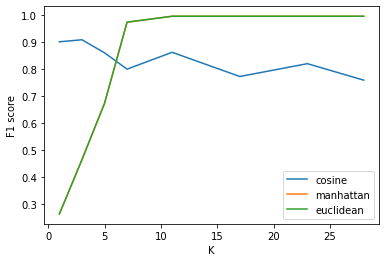

In [64]:
import matplotlib.pyplot as plt
for distanceMethod in distances:
    artemp = [i[3] for i in metrics[distanceMethod]]
    plt.plot(k_list, artemp, label=distanceMethod)
plt.legend()
plt.xlabel('K')
plt.ylabel('F1 score')
plt.show()

### Train and test Sklearn's KNN classifier model on your data (use metric which gave best results on your experimentation with built-from-scratch model.)

***Compare both the models result.***

***What is the time complexity of training using KNN classifier?***

***What is the time complexity while testing? Is KNN a linear classifier or can it learn any boundary?***